# Model Development

### Objective: create a Classifier to predict Marketing Interaction Outcomes

- Train and validate initial model
- Create SparkML Pipeline and save it to Object Store

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.linalg import DenseVector
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

In [2]:
from pyspark.sql.types import IntegerType

In [3]:
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

In [4]:
def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver//100
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = spark.sparkContext.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import sys
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("ModelDevelopment")\
    .config("spark.authenticate", "true")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems", "s3a://demo-aws-1")\
    .config("spark.hadoop.yarn.resourcemanager.principal",os.environ["HADOOP_USER_NAME"])\
    .getOrCreate()

#.master("local[*]")\
    
# **Note:** 
# Our file isn't big, so running it in Spark local mode is fine but you can add the following config 
# if you want to run Spark on the kubernetes cluster 
# 
# > .config("spark.yarn.access.hadoopFileSystems",os.getenv['STORAGE'])\

#.config("spark.authenticate", "true") \
#    .config("spark.yarn.access.hadoopFileSystems", os.environ['STORAGE'])

print("Spark Version: {}".format(spark.version))

Spark Version: 2.4.0.7.1.0.0-714


In [7]:
spark.sql("SELECT * FROM DEFAULT.CUSTOMER_INTERACTIONS_CICD LIMIT 10").show()

AnalysisException: 'org.apache.hadoop.hive.ql.metadata.HiveException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient;'

In [ ]:
hist_DF = spark.sql("SELECT * FROM DEFAULT.CUSTOMER_INTERACTIONS_CICD")

In [8]:
hist_DF = spark.read.option("inferSchema", "true").csv("data/df.csv", header="True")

In [9]:
hist_DF.dtypes

[('recency', 'int'),
 ('history', 'double'),
 ('used_discount', 'int'),
 ('used_bogo', 'int'),
 ('zip_code', 'string'),
 ('is_referral', 'int'),
 ('channel', 'string'),
 ('offer', 'string'),
 ('conversion', 'int'),
 ('score', 'double')]

In [ ]:
hist_DF.dtypes

In [ ]:
hist_DF = hist_DF.withColumn("history", hist_DF["history"].cast(IntegerType()))
hist_DF = hist_DF.withColumn("score", hist_DF["score"].cast(IntegerType()))

In [11]:
df = hist_DF.select("RECENCY", "HISTORY", "USED_DISCOUNT", "USED_BOGO", "ZIP_CODE", "IS_REFERRAL", "CHANNEL", "OFFER", "SCORE", "CONVERSION")

In [12]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in')]

In [13]:
#df = df.select(*num_cols)

In [14]:
#Renaming target feature as "LABEL":
#df = df.withColumnRenamed("CONVERSION","label")

In [15]:
num_cols.remove('CONVERSION')

In [16]:
df.groupby("CONVERSION").count().show()

+----------+-----+
|CONVERSION|count|
+----------+-----+
|         1| 9394|
|         0|54606|
+----------+-----+



#### Creating Pipeline
##### Notice the pipeline does not include the classifier. This is done on purpose so we can split it into two jobs.

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [18]:
def make_pipeline(df):        
    stages= []

    for col in cat_cols:

        stringIndexer = StringIndexer(inputCol = col , outputCol = col + '_StringIndex')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + '_ClassVect'])
        stages += [stringIndexer, encoder]

    #Assembling mixed data type transformations:
    assemblerInputs = [c + "_ClassVect" for c in cat_cols] + num_cols
    #assemblerInputs = num_cols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(df)
    out_df = pipelineModel.transform(df)
    
    return out_df, pipeline

In [19]:
out_df, pipeline = make_pipeline(df)

In [20]:
input_data = out_df.rdd.map(lambda x: (x["CONVERSION"], DenseVector(x["scaledFeatures"])))

In [21]:
df_pre_smote = spark.createDataFrame(input_data, ["CONVERSION", "scaledFeatures"])

In [22]:
df_pre_smote.columns

['CONVERSION', 'scaledFeatures']

In [23]:
df_smote = SmoteSampling(vectorizerFunction(df_pre_smote, "CONVERSION"), k = 3, minorityClass = 1, majorityClass = 0, percentageOver = 400, percentageUnder = 100)

In [24]:
df_smote.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|54606|
|    1|46970|
+-----+-----+



In [25]:
df_smote.columns

['features', 'label']

In [26]:
from pyspark.ml.classification import GBTClassifier

In [27]:
train, test = df_smote.randomSplit([0.8, 0.2], seed=1)

In [28]:
gbt = GBTClassifier()

In [29]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [3, 6]) \
    .addGrid(gbt.maxDepth, [2, 10]) \
    .build()

In [30]:
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=5)

In [31]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

In [32]:
print(cvModel.avgMetrics)

[0.8792182950489035, 0.942826821790374, 0.8792675203530418, 0.944547025381731]


In [33]:
bestModel = cvModel.bestModel
print(bestModel)

GBTClassificationModel (uid=GBTClassifier_28b1fe9fe318) with 6 trees


#### Test Set Evaluation

In [34]:
#Evaluating model with the held out test set:
prediction = cvModel.transform(test)

In [35]:
predictionAndTarget = prediction.select("label", "prediction")

In [36]:
# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

In [37]:
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [38]:
y_true = np.array(predictionAndTarget.select(['label']).collect())
y_pred = np.array(predictionAndTarget.select(['prediction']).collect())

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10921
           1       0.99      0.89      0.94      9303

    accuracy                           0.95     20224
   macro avg       0.95      0.94      0.94     20224
weighted avg       0.95      0.95      0.94     20224



In [40]:
from utils.cm import plot_conf_matrix

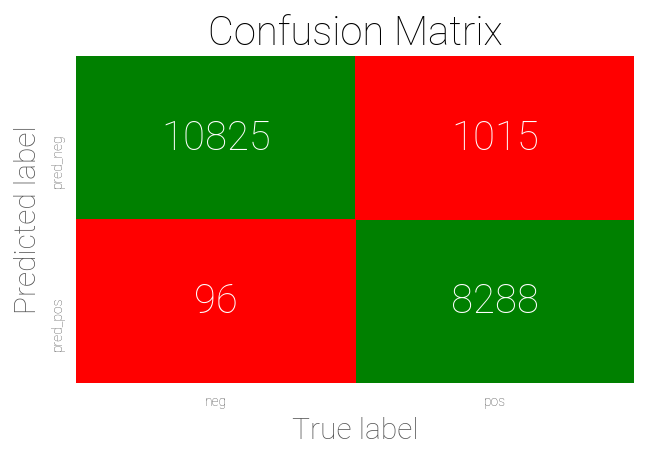

In [41]:
plot_conf_matrix(pd.DataFrame(cm.T, columns=['neg', 'pos'], 
                       index=['pred_neg', 'pred_pos']))

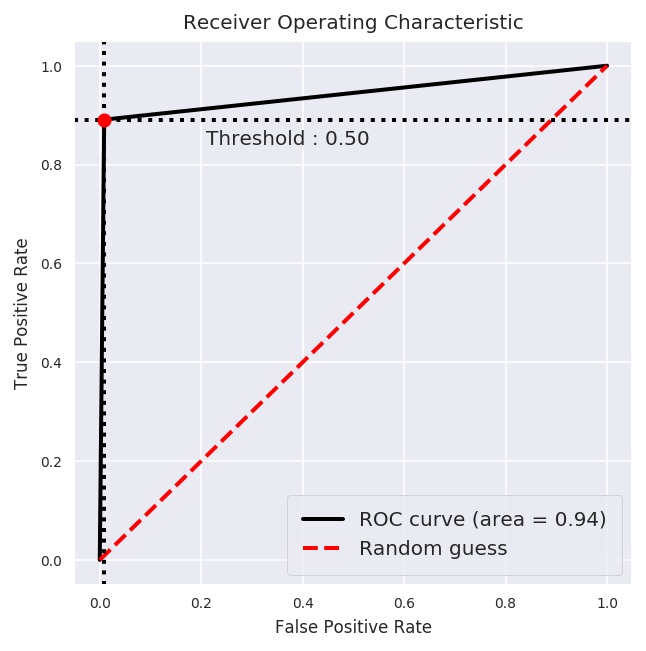

In [42]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_true, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [43]:
#Printing metrics 
#print(acc)
#print(f1)
#print(weightedPrecision)
#print(weightedRecall)
#print(auc)

#### Saving Pipeline and Logistic Regression Model to Object Store

In [44]:
import datetime
import os, time

In [45]:
run_time_suffix = datetime.datetime.now()
run_time_suffix = run_time_suffix.strftime("%d%m%Y%H%M%S")

In [46]:
bestModel.write().overwrite().save("s3a://demo-aws-1/datalake/pdefusco/simple_cicd_models/bestLR_{}".format(run_time_suffix))
pipeline.write().overwrite().save("s3a://demo-aws-1/datalake/pdefusco/simple_cicd_models/pipeline_{}".format(run_time_suffix))

In [47]:
#print("s3a://demo-aws-1/datalake/pdefusco/bestLR_{}".format(run_time_suffix))

In [48]:
spark.stop()